In [1]:
#Save the below parameters to output.txt file
%logstart -o -r -t -q output.txt rotate

In [2]:
def plot_acquisition(v, src=None, rec=None, title='', **kwargs):
    nx=200; nz=151; dx=10; par = {'extent': [0, nx*dx/1000, nz*dx/1000, 0], 'cmap': 'RdBu_r'}; par.update(kwargs);
    plt.figure(figsize=(15,8)); ax = plt.gca(); ax.invert_yaxis(); im = ax.imshow(v/1000, **par); plt.title(title); plt.xlabel('km'); plt.ylabel('km'); 
    if src is not None: plt.scatter(src/1000, 100*np.ones((len(src),1))/1000, 75, color='m'); 
    if rec is not None: plt.scatter(rec/1000, 100*np.ones((len(rec),1))/1000, 3, color='w'); 
    divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05); plt.colorbar(im, cax=cax, label='km/s'); plt.pause

In [3]:
# General info
# using Adam Optimization
# Shuffling sources every epoch
# SCHUSTER's MARMOUSI MODEL

# General parameters
GPU=2     # which GPU to use
plot=False # Plot Intermediate results
sigma=5.0   # Initial model smoothness  

# Inversion parameters
num_batches = 2
num_epochs = 5000

#gamma = 300  # Does not apply, Adam uses lr (learning rate) instead of gamma
# Adam learning rate
lr = 4

# Modeling parameters
freq = 8
dx = 10
dt = 0.001
nt = 4001
num_shots = 18
num_receivers_per_shot = 200

# receiver_spacing = # computed below from ny,dx and num_receivers_per_shot

# Close the ouput.txt file with saved parameters
%logstop 

In [4]:
# Need to restart runtime before this step
import time
import torch
import numpy as np
import scipy.ndimage
import scipy.io
import matplotlib.pyplot as plt
import deepwave
import os
import csv
from sklearn.feature_extraction import image
from skimage.transform import resize
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [5]:
plot=True
# Load the true model
filename='../FWI_Ricardo/Marm151_401.mat'
mat=scipy.io.loadmat(filename)['vel']
mat = resize(mat,(151,200))
#mat = np.loadtxt('marmhard2.dat')
#mat = np.pad(mat,((10,0),(0,0)),'edge') #RB add some water layer
#RB Get model size
ny = np.size(mat,1);
nz = np.size(mat,0);
#RB compute true model mean value and width for future model normalization
max1=np.max(mat)
min1=np.min(mat)
med=(max1+min1)/2.
wid=(max1-min1)/2.

print('vmin=',min1,'vmax=',max1,'vmed=',med,'vwidth=',wid)


vmin= 1500.0 vmax= 3550.000244140625 vmed= 2525.0001220703125 vwidth= 1025.0001220703125


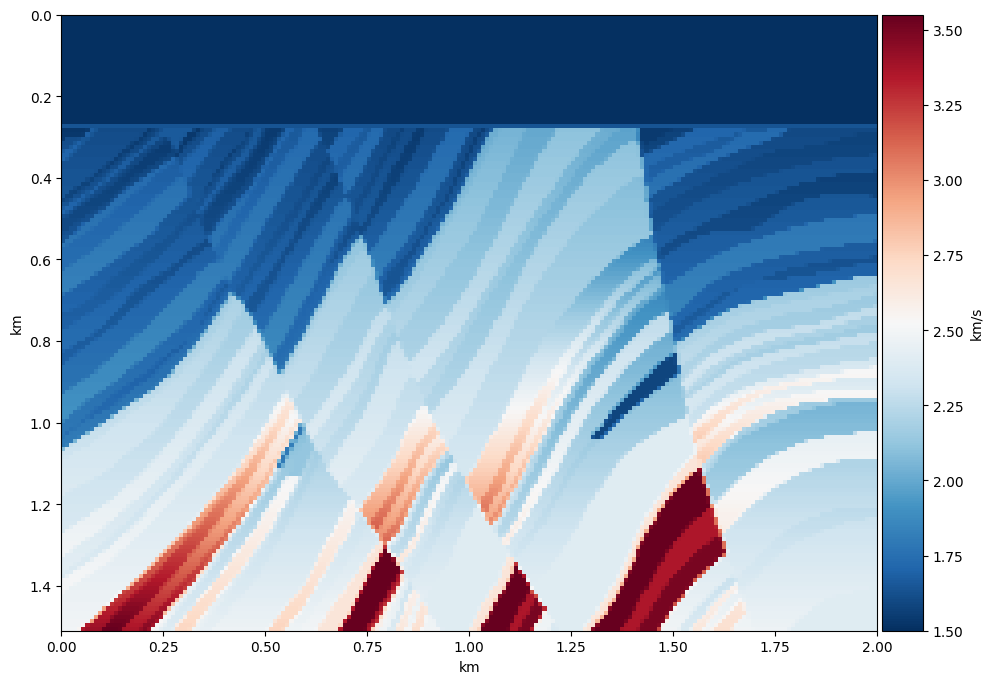

In [6]:
plot_acquisition(mat)

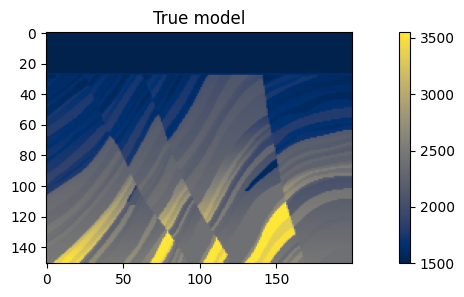

In [7]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(mat,vmin=min1,vmax=max1, aspect=1,cmap='cividis')
    plt.title('True model')
    plt.colorbar()

In [8]:
np.shape(mat)

(151, 200)

In [9]:
#RB Open file to write results
f = open('marmsm_Mod8_log.txt','a+')
writer = csv.writer(f)

#RB Write header
fields=['Epoch','it','loss.item','epoch_loss','it_lap','epoch_lap']
writer.writerow(fields)
f.flush()
os.fsync(f)

In [10]:
# Specify which GPU to use (in multi GPU machines)
torch.cuda.set_device(GPU)  #RB Necessary if device <> 0
GPU_string='cuda:'+str(GPU)
device = torch.device(GPU_string)

In [11]:
# Set parameters
num_dims = 2
#num_shots = 32
num_sources_per_shot = 1
#num_receivers_per_shot = 200

#RB source_spacing = 25.0
#RB receiver_spacing = 10.0
source_spacing = ny * dx / num_shots
receiver_spacing = ny * dx / num_receivers_per_shot
#receiver_spacing = 8.

print('ny=',ny,'nz=',nz,'nt=',nt,'dx=',dx,'freq=',freq)
print('shots=',num_shots,'recs/shot=',num_receivers_per_shot, \
      'ds=',source_spacing,'dr=',receiver_spacing)


ny= 200 nz= 151 nt= 4001 dx= 10 freq= 8
shots= 18 recs/shot= 200 ds= 111.11111111111111 dr= 10.0


In [12]:
# Create arrays containing the source and receiver locations
# x_s: Source locations [num_shots, num_sources_per_shot, num_dimensions]
# x_r: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]
x_s = torch.zeros(num_shots, num_sources_per_shot, num_dims)
x_s[:, 0, 1] = torch.linspace(0,(ny-1)*dx,num_shots)
#x_s[:, 0, 0] = 100. #RB Set source depth

x_r = torch.zeros(num_shots, num_receivers_per_shot, num_dims)
x_r[0, :, 1] = torch.arange(num_receivers_per_shot).float() * receiver_spacing
x_r[:, :, 1] = x_r[0, :, 1].repeat(num_shots, 1)

#RB Shuffle shot coordinates
###idx = torch.randperm(num_shots)
###x_s = x_s.view(-1,2)[idx].view(x_s.size())

#RB Set Receiver depth
#x_r[0, :, 0] = 100.
#x_r[:, :, 0] = x_r[0, :, 0].repeat(num_shots, 1)

# Create true source amplitudes [nt, num_shots, num_sources_per_shot]
# I use Deepwave's Ricker wavelet function. The result is a normal Tensor - you
# can use whatever Tensor you want as the source amplitude.
source_amplitudes_true = (deepwave.wavelets.ricker(freq, nt, dt, 1/freq)
                          .reshape(-1, 1, 1)
                          .repeat(1, num_shots, num_sources_per_shot))

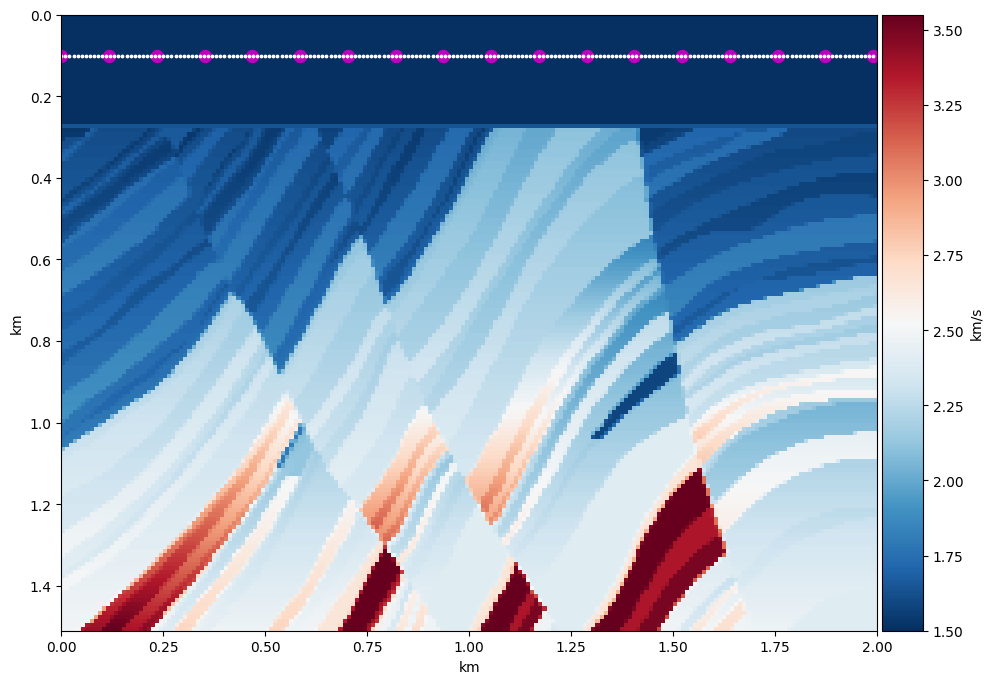

In [13]:
source = x_s[:,0,1].numpy()
receiver = x_r[0,:,1].numpy()
plot_acquisition(mat,source,receiver)

In [17]:
#RB Generate a cte velocy model (with water velocity)
mat2 = np.ones((nz,ny),np.float32)*1500.

mat2[nz-1,int(ny/2)]=max1  # put a pixel with true upper velocity to fix a propagator problem

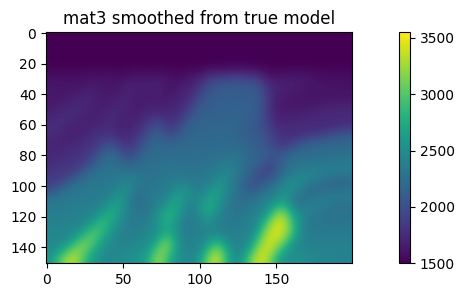

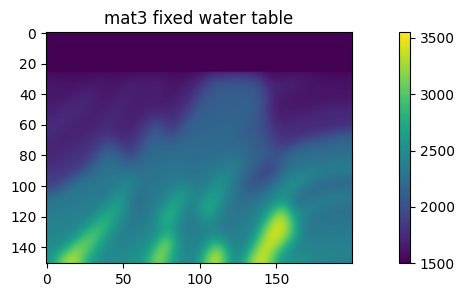

In [18]:
#RB Create a smoothed model

#RB start with true model
mat3 = np.copy(mat)
#RB Filter image heavly
mat3 = scipy.ndimage.gaussian_filter(mat3,sigma=sigma) #10,50  #5%,10%
#for i in range(201):
#    mat3[:,i] = scipy.ndimage.gaussian_filter1d(mat3[:,i],sigma=20)
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(mat3,vmin=min1,vmax=max1)
    plt.title('mat3 smoothed from true model')
    plt.colorbar()

    
#mat3 = 2200*np.ones(np.shape(mat))
#RB Force water table to be 1500 m/s (avoid imperfect direct wav removal)    
mat3[0:26,:]=1500.

#mat3[27:-1,:]=2800.
#RB Plot model
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(mat3,vmin=min1,vmax=max1)
    plt.title('mat3 fixed water table')
    plt.colorbar()

#RB We may want to smooth the water table transition
#RB but I think it's a bad idea (not tested)
# mat3 = scipy.ndimage.gaussian_filter(mat3,sigma=4)

#RB Optionally we may import a initial model from file
#filename='Marm151_401_smooth.mat'
#mat3=scipy.io.loadmat(filename)['vel0']

#RB Ensure that the initial model has the same range of the true model by
#RB forcing one of its slowest pixel to have the true's model lower velocity and
#RB forcing one of its fastest pixel to have the true's model upper velocity
#RB find max & min values of mat3
smin=np.min(mat3)
smax=np.max(mat3)
indmin = np.where(mat3==smin)
indmax = np.where(mat3==smax)
# Take first pixel with minimum velocity and force it to true's model minimum velocity
mat3[indmin[0][0],indmin[1][0]]=min1
# Take first pixel with maximum velocity and force it to true's model maximum velocity
mat3[indmax[0][0],indmax[1][0]]=max1

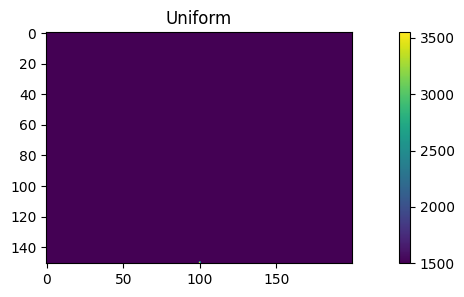

In [19]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(mat2,vmin=min1,vmax=max1, aspect=1)
    plt.title('Uniform')
    plt.colorbar()

In [20]:
#RB Convert models to PyTorch Tensors
model_true = torch.Tensor(mat) # Convert to a PyTorch Tensor
model_cte = torch.Tensor(mat2) # Convert to a PyTorch Tensor

In [23]:
out = deepwave.scalar(model_true.to(device), dx, dt, source_amplitudes=source_amplitudes_true,
             source_locations=x_s,
             receiver_locations=x_r,
             accuracy=8,
             pml_freq=freq)

RuntimeError: Expected source_amplitudes.shape[0] == source_locations.shape[0].

In [21]:
###### Create 'true' data 
prop = deepwave.scalar({'vp': model_true.to(device)}, dx)
#receiver_amplitudes_all = prop(source_amplitudes_true.to(device),
#                                x_s.to(device),
                                x_r.to(device), dt).cpu()
#seis=np.squeeze(receiver_amplitudes_all.cpu().detach().numpy())
#seis = seis.swapaxes(1,2)
#seis = seis.swapaxes(0,1)
#receiver_amplitudes_all = receiver_amplitudes_all.swapaxes(1,2)

AttributeError: 'function' object has no attribute 'Propagator'

In [ ]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(receiver_amplitudes_all[:,2].cpu().detach().numpy(),vmin=-.05,vmax=.05, aspect='auto')
    
    plt.title('Model seismogram')

In [ ]:
# Create direct arrivals data
prop2 = deepwave.scalar.Propagator({'vp': model_cte.to(device)}, dx)
receiver_amplitudes_cte = prop2(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()

In [ ]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(receiver_amplitudes_cte[:,2].cpu().detach().numpy(),vmin=-.05,vmax=.05, aspect='auto')
    plt.title('Direct wave seismogram')

In [ ]:
# Exclude direct waves from true data (they don't bring info from subsurface)
receiver_amplitudes_true = receiver_amplitudes_all

In [ ]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(receiver_amplitudes_true[:,2].cpu().detach().numpy(),vmin=-.05,vmax=.05, aspect='auto')
    plt.title('Model seismogram w direct waves removed')

In [ ]:
#RB Normalize initial model to (-1,1) range
#model_init = (mat3-med)/wid
#RB_No_normalization
model_init = mat3

In [ ]:
# Convert to Pytorch tensor
#model_init = torch.from_numpy(np.float32(model_init))
model_init = torch.Tensor(model_init)

# Make a copy so at the end we can see how far we came from the initial model
model = model_init.clone()
model = model.to(device)
model.requires_grad = True

In [ ]:
#RB AS I am not inverting for source, I could just do
#RB source_amplitudes = source_amplitudes_true.clone().to(device)
#RB instead of all code below

# Create initial guess source amplitude for inversion
# I will assume that the true source amplitude is the same for every shot
# so I will just create one source amplitude, and PyTorch will backpropagate
# updates to it from every shot
source_amplitudes_init = (deepwave.wavelets.ricker(freq, nt, dt, 1/freq)
                          .reshape(-1, 1, 1))
source_amplitudes = source_amplitudes_init.clone()
source_amplitudes = source_amplitudes.to(device)
#source_amplitudes.requires_grad_(); # Alternative way of requiring gradient

In [ ]:
# To demonstrate chaining operations, during the inversion I will normalise the
# predicted receiver amplitudes so that each trace has a maximum value of 1.
# This will be compared (in the cost function) with the true data that has been
# similarly scaled. I apply that scaling to the true data now.
# This sort of scaling might be useful for real data where the absolute
# amplitudes are often not meaningful.
rcv_amps_true_max, _ = receiver_amplitudes_true.max(dim=0, keepdim=True)
rcv_amps_true_norm = receiver_amplitudes_true / rcv_amps_true_max

In [ ]:
# Set-up inversion
#gamma = 300
criterion = torch.nn.MSELoss()
#RB optimizer = torch.optim.SGD([{'params': model }],lr = 100000., momentum=0)
optimizer = torch.optim.Adam([{'params': [model], 'lr': lr}])

In [ ]:
#%%capture cap --no-stderr 
# The line above captures the output of this cell to the variable cap

# Iterative inversion loop
t_start = time.time()

##num_batches = 32 # split data into batches for speed and reduced memory use
num_shots_per_batch = int(num_shots / num_batches)
##num_epochs = 1000 # Pass through the entire dataset 30 times

#vmin, vmax = np.percentile(model_true.numpy(), [2,98]) # For plotting
vmin = min1
vmax = max1
#vmin=-1
#vmax= 1
# Temperature coefficient
##Tk =50



for epoch in range(num_epochs):
    ep_start=time.time()
    print('Processing Epoch:',epoch)
    epoch_loss = 0.0
    
    #RB Shuffle shot coordinates
    idx = torch.randperm(num_shots)
    x_s = x_s.view(-1,2)[idx].view(x_s.size())
    #RB Shuffle true's seismograms sources with same random values
    rcv_amps_true_norm = rcv_amps_true_norm[:,idx,:]
    #RB Shuffle direct wave seismograms sources with the same random values
    receiver_amplitudes_cte = receiver_amplitudes_cte[:,idx,:]
    print(np.shape(rcv_amps_true_norm))
    
    for it in range(num_batches):
        it_start = time.time()
        ###print('    Processing Batch:',it,' of', num_batches)
        
        optimizer.zero_grad()
        #if model.grad is not None:
        #    model.grad.data.zero_()
        #    print('Preexinting Model Grad zeroed')
            
        #RB Denormalize model to perform forward propagation
        #model2=model*wid+med
        #RB or no denormalization if using Adam
        model2=model.clone()
        #RB Clamp the model within acceptable range
        model2=torch.clamp(model,min=min1,max=max1)        
        
        #RB Make sure the model have same range of velocities of true's model (fix propag issue)
        #RB forcing one of its slowest pixel to have the true's model lower velocity and
        #RB forcing one of its fastest pixel to have the true's model upper velocity       
        #RB find max & min values of model2
        smin=torch.min(model2)
        smax=torch.max(model2)
        indmin = torch.where(model2==smin)
        indmax = torch.where(model2==smax)
        # Take first pixel with minimum velocity and force it to true's model minimum velocity
        model2[indmin[0][0],indmin[1][0]]=min1
        # Take first pixel with maximum velocity and force it to true's model maximum velocity
        model2[indmax[0][0],indmax[1][0]]=max1
        
        prop3 = deepwave.scalar.Propagator({'vp': model2}, dx)
        batch_src_amps = source_amplitudes.repeat(1, num_shots_per_batch, 1)
        batch_rcv_amps_true = rcv_amps_true_norm[:,it::num_batches].to(device)
        
        #RB Alternative normalization (normalizing to dTrue amplitude range)
        #batch_rcv_amps_true_max, _ = batch_rcv_amps_true.max(dim=0, keepdim=True)
        
        #RB get the seismogram of the direct wave for current batch
        batch_rcv_amps_cte = receiver_amplitudes_cte[:,it::num_batches].to(device)
        
        #RB get the current batch source & receiver coordinates
        batch_x_s = x_s[it::num_batches].to(device)
        batch_x_r = x_r[it::num_batches].to(device)

        #print('FWD Propag')
        #timer_a = time.time()
        
        batch_rcv_amps_pred = prop3(batch_src_amps, batch_x_s, batch_x_r, dt)
        
        #RB Subtract direct wave on all seismograms of current batch
        batch_rcv_amps_pred = batch_rcv_amps_pred - batch_rcv_amps_cte
        
        #RB Normalize
        batch_rcv_amps_pred_max, _ = batch_rcv_amps_pred.max(dim=0, keepdim=True)
        batch_rcv_amps_pred_norm = batch_rcv_amps_pred / batch_rcv_amps_pred_max
        
        print("shape of predicted")
        print(np.shape(batch_rcv_amps_pred_norm))

        loss = criterion(batch_rcv_amps_pred_norm, batch_rcv_amps_true)            
        epoch_loss += loss.item()
        
        #timer_a = time.time()
        #print('Lap=',timer_a-timer_b)
        
        
        #print('Backpropagation')
    
        loss.backward()
        model.grad[0:26,:]=0.
        
        
        #timer_b = time.time()
        #print('Lap=',timer_b-timer_a)
        
        #RB Hill climbing factor computation
        #low = 1-2*np.exp(-epoch/Tk)
        #alpha = np.random.uniform(low=low,high=1)
        #alpha = 1.
        
        #print('Model update')
        #with torch.no_grad():                
            #RB update model
        #    model =  model - torch.tanh(alpha*gamma*model.grad)                
        #model.requires_grad = True        
        optimizer.step()
        
        
        # Clamp model to acceptable range
        #with torch.no_grad():
        #    model=torch.clamp(model,min=min,max=max)
        #model.requires_grad = True
        
        it_end = time.time()
        #print('Lap=',it_end-timer_b)
        
        
    #RB Write variables to file at each epoch
    fields=[epoch,it,loss.item(),epoch_loss, it_end - it_start,it_end - ep_start]
    writer.writerow(fields)
    f.flush()
    os.fsync(f)
    
    print('Epoch:', epoch, 'Loss: ', epoch_loss)
    img = np.array(model.cpu().detach().numpy())

    filename='Marmsm_Mod8_epoch_'+str(epoch)+'.mat'
    scipy.io.savemat(filename, mdict={'Model': img})
       
    if epoch % 50 == 0:
        
        if plot==True:
            plt.figure(figsize=(8, 4))
            plt.imshow(model.cpu().detach().numpy(), vmin=vmin, vmax=vmax,cmap='viridis')
            plt.show() 
    
    epoch+=1

t_end = time.time()
print('Runtime:', t_end - t_start)

In [ ]:
plt.imshow(img)
plt.colorbar()

In [ ]:
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiT/')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiT/')

          
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiT/trainA')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiT/trainB')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiT/trainC')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiT/trainD')

os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiT/testA')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiT/testB')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiT/testC')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiT/testD')

os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiT/trainA')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiT/trainB')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiT/trainC')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiT/trainD')

os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiT/testA')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiT/testB')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiT/testC')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiT/testD')

In [ ]:
plt.figure(figsize=(12, 8))
plt.imshow(mat3,vmin=1500,vmax=3550,cmap='jet',aspect='auto')
plt.colorbar()

In [ ]:
seis = seis.swapaxes(0,1)
#mat3 = 2200*np.ones(np.shape(mat))
#mat3[0:26,:] = 1500
A = seis
B = mat
C = mat3

for kk in range(1,2):
    
    #kk = 1
    D = torch.randn([1,8])
            
    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiT/trainA/'+str(kk)+'.npy','wb')
    np.save(file,A)
    file.close()

    
    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiT/trainB/'+str(kk)+'.npy','wb')
    np.save(file,B)
    file.close()


    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiT/trainC/'+str(kk)+'.npy','wb')
    np.save(file,C)
    file.close()

    
    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiT/trainD/'+str(kk)+'.npy','wb')
    np.save(file,D)
    file.close()


In [ ]:
plt.imshow(C)

In [ ]:
plt.imshow(mat3)
plt.colorbar()

In [ ]:
np.min(mat)

In [ ]:
for kk in range(150,151):
    
    #kk = 1
    #D = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi/ZZConstant0ep'+str(kk)+'.npy')
            
    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiT/testA/'+str(kk)+'.npy','wb')
    np.save(file,A)
    file.close()
    

    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiT/testB/'+str(kk)+'.npy','wb')
    np.save(file,B)
    file.close()


    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiT/testC/'+str(kk)+'.npy','wb')
    np.save(file,C)
    file.close()
    

    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiT/testD/'+str(kk)+'.npy','wb')
    np.save(file,D)
    file.close()

In [ ]:
def plotFakeVelNewStd():
    
    #create figure
    #fig1 = plt.figure(figsize=(9,9))
    #fig2 = plt.figure(figsize=(15,15))
    
    rows = 3
    columns = 3
    matVel = np.zeros((50,1,100,200))
    for k in range(50):
        filename='/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Output'+str(k)+'/'    
        for i in range(1):
            #fig.add_subplot(rows,columns,i+1)
            #kk=starting+i
            onefile = filename+'150_fake_BT.npy'
            mat=np.load(onefile)
            mat = mat*1000
            matVel[k,i,:,:] = mat
            
    mean = np.mean(matVel,axis=0)
    std = np.std(matVel,axis=0)
    plt.imshow(np.squeeze(std),'jet',vmin=0,vmax=5)
    plt.colorbar()

In [ ]:
plotFakeVelNewStd()

In [ ]:
np.shape(C)

In [ ]:
from skimage.util import random_noise
b = random_noise(A, var=0.1**2)
plt.figure(figsize=(12, 3))
plt.imshow(b[2,:,:],vmin=-.05,vmax=.05, aspect='auto')
    
plt.title('Model seismogram')

In [ ]:
np.max(B)

In [ ]:
np.shape(A)

In [ ]:
Z1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi/ZZConstant0ep10.npy')
Z1 = np.squeeze(np.squeeze(Z1))
#plt.imshow(Z1)
#plt.colorbar()
plt.plot(Z1)

In [ ]:
plt.plot(mat[:,100])

In [ ]:
np.shape(mat)

In [ ]:
np.shape(A)


In [ ]:
plt.imshow(mat3)

In [ ]:
np.shape(mat)

In [ ]:
np.shape(A)

In [ ]:
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Marmousi2/')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Marmousi2/')

          
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Marmousi2/trainA')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Marmousi2/trainB')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Marmousi2/trainC')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Marmousi2/trainD')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Marmousi2/trainA')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Marmousi2/trainB')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Marmousi2/trainC')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Marmousi2/trainD')

os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Marmousi2/testA')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Marmousi2/testB')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Marmousi2/testC')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Marmousi2/testD')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Marmousi2/testA')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Marmousi2/testB')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Marmousi2/testC')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Marmousi2/testD')


In [ ]:
from sklearn.feature_extraction import image
from skimage.transform import resize
patches = image.extract_patches_2d(mat,(5,15),max_patches=500)


In [ ]:
np.shape(patches)

In [ ]:
rt = 300
po1 = np.squeeze(patches[rt,:,:])
po1 = resize(po1,(151,201))
plt.imshow(po1)
plt.colorbar()

In [ ]:
kk = 0
for kk in range(500):
    po = np.squeeze(patches[kk,:,:])
    po = resize(po,(151,201))
    B = po
    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Marmousi2/trainB/'+str(kk+1)+'.npy','wb')
    np.save(file,B)
    file.close()
    A = po
    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Marmousi2/trainA/'+str(kk+1)+'.npy','wb')
    np.save(file,A)
    file.close()
    C = po
    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Marmousi2/trainC/'+str(kk+1)+'.npy','wb')
    np.save(file,C)
    file.close()
    D = po
    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Marmousi2/trainD/'+str(kk+1)+'.npy','wb')
    np.save(file,D)
    file.close()

In [ ]:
plt.imshow(np.squeeze(patches[4,:,:]))

In [ ]:
kk = 0
po1 = resize(mat,(151,201))
B = po1
file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Marmousi2/testB/'+str(kk+1)+'.npy','wb')
np.save(file,B)
file.close()
A = po1
file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Marmousi2/testA/'+str(kk+1)+'.npy','wb')
np.save(file,A)
file.close()
C = po1
file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Marmousi2/testC/'+str(kk+1)+'.npy','wb')
np.save(file,C)
file.close()
D = po1
file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Marmousi2/testD/'+str(kk+1)+'.npy','wb')
np.save(file,D)
file.close()

In [ ]:
pq = resize(mat,(151,201))
plt.imshow(pq)

In [ ]:
port = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi/Gr1ad131ep1.npy')
np.shape(port)
#plt.fig_size(8,12)
plt.imshow(np.squeeze(port[0,1,:,:]))

In [ ]:
port = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi/netgrad.npy')
np.shape(port)
#plt.fig_size(8,12)
#plt.imshow(np.squeeze(port[0,1,:,:]))
plt.imshow(port)
port

In [ ]:
port = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi/net1out1.npy')
np.shape(port)
#plt.fig_size(8,12)
#plt.imshow(np.squeeze(port[0,1,:,:]))
plt.imshow(port)
port

In [ ]:
grad = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi22/GradAD0ep3000.npy')
fake210 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi21/FakeAD0ep3000.npy')
real = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi21/RealAD0ep1080.npy')
#np.shape(port)
#np.shape(port)
plt.figure(figsize=(15, 5))
plt.imshow(np.squeeze(grad[0,:,:]))
plt.colorbar()

In [ ]:
np.shape(grad[0,:,:])

In [ ]:
g1 = np.arange(100)
g1**2
pot = np.tile(g1,(200,1))
plt.imshow(np.transpose(pot))

In [ ]:
plt.figure(figsize=(15, 8))
plt.imshow(np.squeeze(fake210[0,:,:]),vmin=1500,vmax=3550, aspect=1)
plt.colorbar()
#np.min(fake210[0,:,0,:])
#fake210[0,:,:,:]

In [ ]:
plt.figure(figsize=(15, 8))
plt.imshow(np.squeeze(real[0,:,:]), vmin=1500, vmax=3550, aspect=1)
plt.colorbar()
np.min(real[0,:,:])
np.max(real[0,:,:])

In [ ]:
real1 = np.squeeze(real[0,:,:])
fake1 = np.squeeze(fake210[0,:,:])
fig = plt.figure(figsize=(15, 5))
plt.plot(real1[:,100],'r')
plt.plot(fake1[:,100],'b')
plt.tight_layout()

In [ ]:
np.shape(real1)

In [ ]:
plt.figure(figsize=(15, 5))
plt.imshow(np.squeeze(fake[0,:,:]*1000), vmin=1500, vmax=4800, aspect=1)
plt.colorbar()
#plt.plot(np.squeeze(fake210[2,:,40]))

In [ ]:
plt.imshow(np.squeeze(fake[0,:,:,:]))
plt.colorbar()

In [ ]:
plt.imshow(np.squeeze(real[0,:,:,:]))
plt.colorbar()

In [ ]:
po = np.squeeze(fake[:,:,:]*1000) - mat
plt.imshow(po)

In [ ]:
truegrad = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi/po.npy')
np.shape(truegrad)
#plt.imshow(np.squeeze(truegrad[:,:]*100))
plt.imshow(np.squeeze(truegrad))

plt.colorbar()

In [ ]:
truegrad

In [ ]:
inverted = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi/Mart28000ep800.npy')
inverted = np.squeeze(np.squeeze(inverted*100))
plt.figure(figsize=(12, 8))
plt.imshow(inverted,vmin=1500,vmax=3550,cmap='jet',aspect='auto')
plt.colorbar()

In [ ]:
amp = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi/rcv_amplitudes.npy')
print("standard deviation :",np.std(amp))
np.shape(amp)
plt.figure(figsize=(12, 4))
plt.imshow(amp[:,0,:],vmin=-.05,vmax=.05, aspect='auto')
plt.colorbar()

In [ ]:
amp = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi/rcv_amplitudes_true.npy')
np.shape(amp)
plt.figure(figsize=(12, 4))
plt.imshow(amp[:,3,:],vmin=-.05,vmax=.05, aspect='auto')
plt.colorbar()

In [ ]:
amp = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi/rcv_amplitudes_true_cte.npy')
np.shape(amp)
#plt.figure(figsize=(12, 4))
#plt.colorbar()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
amp = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi/net1o420ut1.npy')
np.shape(amp)
plt.figure(figsize=(8, 8))
plt.imshow(amp,vmin=1500,vmax=3550)
plt.colorbar()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
amp = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi/FakeAD0ep500.npy')
amp = amp
amp = np.squeeze(np.squeeze(amp))
#np.shape(amp)
plt.figure(figsize=(12, 8))
plt.imshow(amp,vmin=1500,vmax=3550,cmap='jet',aspect='auto')
plt.colorbar()

In [ ]:
np.min(amp)

In [ ]:
np.max(np.abs(truegrad))

In [ ]:
plt.imshow(np.squeeze(real[1,:,:,:]))
plt.colorbar()

In [ ]:
data = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi/inputs.npy')
np.shape(data)

In [ ]:
plot = True
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(data[0,1],vmin=-.05,vmax=.05, aspect='auto')
    plt.title('Model seismogram')

In [ ]:
plt.imshow(np.squeeze(real[4,:,:,:]))
plt.colorbar()

In [ ]:
plt.imshow(np.squeeze(fake[4,:,:,:]))
plt.colorbar()

In [ ]:
port[3,:,:,:]

In [ ]:
port = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi/FinalInvConstant.npy')
plt.imshow(np.squeeze(np.squeeze(port))*100)
plt.colorbar()

In [ ]:
ppt4 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi/MT3M0ep15.npy')
ppt3 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi/MT3M0ep15.npy')

In [ ]:
ppt = np.squeeze(ppt4)
#ppt = np.squeeze(ppt)
plt.imshow(ppt*100)


In [ ]:
plt.plot(ppt[:,100])

In [ ]:
plt.imshow(mat3)
plt.colorbar()

In [ ]:
AllVal = np.zeros((151,201,199))
for i in range(199):
    ppt1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi/FinalInv'+str(i)+'ep1.npy')
    ppt1 = np.squeeze(np.squeeze(ppt1))
    AllVal[:,:,i] = ppt1*100
Mean = np.mean(AllVal,axis=2)
Std = np.std(AllVal,axis=2)
    
    

In [ ]:
plt.imshow(Mean)
plt.colorbar()

In [ ]:
plt.imshow(Std)

In [ ]:
plt.imshow(np.squeeze(np.squeeze(ppt2-ppt1)))

In [ ]:
NX = 800;
NY = 186;
DH = 25.0;
f = open("AllModels/overthrust_true.vp")
data_type = np.dtype ('float32').newbyteorder ('<')
overthrust = np.fromfile (f, dtype=data_type)
overthrust = overthrust.reshape(NX,NY)
overthrust = np.transpose(overthrust)
overthrust = overthrust[0:130,0:550]
overthrust = resize(overthrust, (151, 201))
#mod_true = np.flipud(mod_true)

In [ ]:
plt.imshow(overthrust)
plt.colorbar()

In [ ]:
import pandas as pd 
np.loadtxt('/disk/student/adhara/Fall2021/PhysicsBasedFWI/checkpoints/AutoModel25OctfulldataNoPhyDropOut/loss_log.txt')

In [ ]:
with open('/disk/student/adhara/Fall2021/PhysicsBasedFWI/checkpoints/AutoModel25OctfulldataNoPhyDropOut/loss_log.txt') as f:
    lines = f.readlines()